# Testing to see if the regression lines between two datasets are significantly different
Note that this is built up from https://statisticsbyjim.com/regression/comparing-regression-lines/

a worked example of the above (to confirm that I could replicate it in python) is presented at the bottom of this worksheet

In [490]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.datasets import make_regression


### generate random data which potentially has a breakpoint

In [504]:

xa, ya = make_regression(n_samples=100, n_features=1, noise=20)
xa=xa[:,0]
xa -= np.min(xa)
ya -= np.min(ya)
my_sort = np.argsort(xa)
xa = xa[my_sort]
ya = ya[my_sort]
xb, yb = make_regression(n_samples=100, n_features=1, noise=20)
xb=xb[:,0]
xb -= np.min(xb)
yb -= np.min(yb)
my_sort = np.argsort(xb)
xb = xb[my_sort]
xb += np.max(xa)
yb = yb[my_sort]
yb += np.max(ya)
x = np.concatenate((xa,xb))
y = np.concatenate((ya,yb))





### Calculating the piecewise linear regression from 1st principles

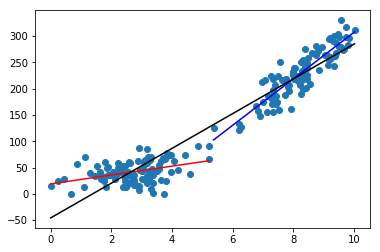

In [505]:

#Wikipedia: The least squares method applied separately to each segment, by which the two regression lines are made to fit the data set as closely as possible while minimizing the sum of squares of the differences (SSD) between observed (y) and calculated (Yr) values of the dependent variable,
my_sort = np.argsort(x)
x = x[my_sort]
y = y[my_sort]

threshold_p_value = 0.05

piecewise_square_sum = np.zeros(len(x))
piecewise_square_sum[:] = np.nan
for i in 1+np.arange(len(x)-1):
    #loop through each potential split of the data. e.g. [a,b,c,d,e], split is [a] and [b,c,d,e] then [a,b] and [c,d,e] etc.
    x1,x2 = x[0:i],x[i::]
    y1,y2 = y[0:i],y[i::]
    # calculate the least squares regression from the left hand side of the split
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
    # calculate the sum of the square of the distances of each point in the left hand of the split from the best fit line
    sum_squares1 = np.sum([np.square(y1[i] - ((slope1 * x1[i])+ intercept1)) for i in range(len(x1))])
    # calculate the least squares regression from the right hand side of the split
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
    # calculate the sum of the square of the distances of each point in the right hand of the split from the best fit line
    sum_squares2 = np.sum([np.square(y2[i] - ((slope2 * x2[i])+ intercept2)) for i in range(len(x2))])
    #test if the p-values for both segments (left and right) are significant (using value held by threshold_p_value).
    # If it is add together the sums of the squares of the distances from teh two segments note this in an array and move on to the next split
    if (p_value1 <= threshold_p_value) and (p_value2 <= threshold_p_value):
        piecewise_square_sum[i] = sum_squares1 + sum_squares2

# check that we have some splits which have significant p-values for both left and right (i.e. we have at least one splot whichh gave us two vioable regressions)
if False in np.isnan(piecewise_square_sum):
    # find the split which gave the lowest sum of the squared distances across the two segments
    i2 = np.where(piecewise_square_sum == np.nanmin(piecewise_square_sum))[0][0]
    x1,x2 = x[0:i2],x[i2::]
    y1,y2 = y[0:i2],y[i2::]
    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    standard_linear_regression_square_sum = np.sum([np.square(y[i] - ((slope * x[i])+ intercept)) for i in range(len(x))])

    # check that the piecewise regression, i.e. two separate lines gave a better fir than just using a single regression line
    if standard_linear_regression_square_sum < piecewise_square_sum[i2]:
        print 'single regression line provides the best fit'
    else:
        #plot the results
        plt.scatter(x,y)
        x1b = np.linspace(min(x1),max(x1),3)
        plt.plot(x1b,(slope1 * x1b)+ intercept1,'r')
        x2b = np.linspace(min(x2),max(x2),3)
        plt.plot(x2b,(slope2 * x2b)+ intercept2,'b')

        # single linear regression
        x1c = np.linspace(min(x),max(x),3)
        plt.plot(x1c,(slope * x1c)+ intercept,'k')

## test if the two regressions are significantly different

### put the data into a pandas dataframe (just to hhelp understand what I am doing)

In [506]:
x3 = np.concatenate((x1,x2))
y3 = np.concatenate((y1,y2))
condition = np.concatenate((x1_string,x2_string))
x1_string = np.empty(len(x1), dtype="S1")
x1_string[:] = 'A'
x2_string = np.empty(len(x2), dtype="S1")
x2_string[:] = 'B'
data = {'Input':x3, 'Output':y3,'Condition':condition} 
df2 = pd.DataFrame(data) 

### calculate the p-value describing whether the two regressions are significantluy different

In [507]:
#https://statisticsbyjim.com/regression/comparing-regression-lines/
# data: https://statisticsbyjim.com/wp-content/uploads/2017/07/TestSlopes.csv
import statsmodels.formula.api as smf
mod = smf.ols(formula='Output ~ Input * Condition', data=df2)
res = mod.fit()
# print(res.params)
# print(res.pvalues)
pvalue_for_testing_regression_differences = res.pvalues[3]
print 'p-value for difference in the two slopes:'
print pvalue_for_testing_regression_differences

p-value for difference in the two slopes:
6.96775771689e-27


# Below is the example I was working from to test the diff slopes

In [417]:
#https://statisticsbyjim.com/regression/comparing-regression-lines/
# data: https://statisticsbyjim.com/wp-content/uploads/2017/07/TestSlopes.csv
df = pd.read_csv('/Users/ph290/Downloads/TestSlopes.csv')
import statsmodels.formula.api as smf
mod = smf.ols(formula='Output ~ Input * Condition', data=df)
res = mod.fit()
print(res.params)
print(res.pvalues)
pvalue_for_testing_regression_differences = res.pvalues[3]
print '#########################################'
print(res.summary())
# The p-value for Input is 0.000, which indicates that the relationship between Input and Output is statistically significant.
# Next, look at Condition. This term is the main effect that tests for the difference between the constants. The coefficient indicates that the difference between the constants is -2.36, but the p-value is only 0.093. The lack of statistical significance indicates that we can’t conclude the constants are different.
# Now, let’s move on to the interaction term (Input*Condition). The coefficient of 0.469 represents the difference between the coefficient for Condition A and Condition B. The p-value of 0.000 indicates that this difference is statistically significant. We can reject the null hypothesis that the difference is zero. In other words, we can conclude that Condition affects the relationship between Input and Output.



Intercept               9.099022
Condition[T.B]         -2.359412
Input                   1.535910
Input:Condition[T.B]    0.469138
dtype: float64
Intercept               4.813416e-14
Condition[T.B]          9.284673e-02
Input                   1.015199e-29
Input:Condition[T.B]    1.325837e-04
dtype: float64
#########################################
                            OLS Regression Results                            
Dep. Variable:                 Output   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     319.4
Date:                Mon, 15 Jun 2020   Prob (F-statistic):           3.00e-42
Time:                        21:49:31   Log-Likelihood:                -191.42
No. Observations:                  78   AIC:                             390.8
Df Residuals:                      74   BIC:                             400.3
Df Model:       